#### Kernel demonstrating use of XGB and LGBM Regressor for solving the LearnX Sales Forecasting Problem. It includes exploratory data analysis, preprocessing steps, basic feature engineering and modelling steps with K fold validation and Bayesian Optimization.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11686 sha256=75a38b87064e2946159d399f39465b7edc52be53659376ee29a8ebecfd721ba7
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import sklearn
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import mean_squared_log_error

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.

Reading the datasets

In [ ]:
# Change your location
train = pd.read_csv('/content/drive/MyDrive/Sales-Forecasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Sales-Forecasting/test_6hcImfB.csv')
sample = pd.read_csv('/content/drive/MyDrive/Sales-Forecasting/sample_submission_ROrnLUk.csv')

In [ ]:
# Columns of the data set
print(list(train.columns))
print(list(test.columns))

['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type', 'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic', 'Competition_Metric', 'Sales']
['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type', 'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'Competition_Metric']


* Sales is the target column we have to predict and the rest are the features

* We notice that User Traffic in the train set is missing in the test data

In [ ]:
print(train.shape)
print(test.shape)

(512087, 11)
(36000, 9)


* We find that the training set has 512087 entries across 11 columns whereas the testing set has 36000 entries across only 9 columns
* This suggests that the columns missing in test set are the Sales and User_Traffic

In [ ]:
train.dtypes

ID                      int64
Day_No                  int64
Course_ID               int64
Course_Domain          object
Course_Type            object
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
User_Traffic            int64
Competition_Metric    float64
Sales                   int64
dtype: object

In [ ]:
test.dtypes

ID                      int64
Day_No                  int64
Course_ID               int64
Course_Domain          object
Course_Type            object
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
Competition_Metric    float64
dtype: object

Descriptive Statistics

In [ ]:
train.describe()

,ID,Day_No,Course_ID,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
count,512087.000000,512087.000000,512087.000000,512087.000000,512087.000000,512087.000000,512087.000000,510323.000000,512087.000000
mean,274007.300650,434.917869,300.388344,0.380244,0.031639,0.488968,15375.101198,0.073345,120.826924
std,158228.834029,256.044161,173.365787,0.485447,0.175038,0.499879,7727.231205,0.100115,54.355258
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000
25%,136962.500000,214.000000,150.000000,0.000000,0.000000,0.000000,10584.000000,0.010000,84.000000
50%,273984.000000,427.000000,300.000000,0.000000,0.000000,0.000000,13776.000000,0.035000,111.000000
75%,411065.500000,658.000000,451.000000,1.000000,0.000000,1.000000,18123.000000,0.094000,146.000000
max,548027.000000,882.000000,600.000000,1.000000,1.000000,1.000000,100002.000000,0.768000,682.000000


In [ ]:
train.describe(include='object')

,Course_Domain,Course_Type
count,512087,512087
unique,4,3
top,Development,Course
freq,264295,262747


In [ ]:
test.describe()

,ID,Day_No,Course_ID,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric
count,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,35880.000000
mean,274566.035000,912.500000,300.500000,0.400000,0.010972,0.501667,0.072938
std,158083.869473,17.318343,173.207246,0.489905,0.104174,0.500004,0.099412
min,883.000000,883.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,137730.250000,897.750000,150.750000,0.000000,0.000000,0.000000,0.010000
50%,274761.500000,912.500000,300.500000,0.000000,0.000000,1.000000,0.034500
75%,410872.750000,927.250000,450.250000,1.000000,0.000000,1.000000,0.094000
max,548087.000000,942.000000,600.000000,1.000000,1.000000,1.000000,0.768000


In [ ]:
test.describe(include='object')

,Course_Domain,Course_Type
count,36000,36000
unique,4,3
top,Development,Course
freq,18480,18600


##Exploratory Data Analysis

In [ ]:
# checking for null values
train.isnull().sum()

ID                       0
Day_No                   0
Course_ID                0
Course_Domain            0
Course_Type              0
Short_Promotion          0
Public_Holiday           0
Long_Promotion           0
User_Traffic             0
Competition_Metric    1764
Sales                    0
dtype: int64

In [ ]:
test.isnull().sum()

ID                      0
Day_No                  0
Course_ID               0
Course_Domain           0
Course_Type             0
Short_Promotion         0
Public_Holiday          0
Long_Promotion          0
Competition_Metric    120
dtype: int64

We find that there are missing values in the Competition_Metric for both train and test sets.

In [ ]:
train.ID.nunique()

512087

In [ ]:
train.apply(lambda x : len(x.unique()))

ID                    512087
Day_No                   882
Course_ID                600
Course_Domain              4
Course_Type                3
Short_Promotion            2
Public_Holiday             2
Long_Promotion             2
User_Traffic            3475
Competition_Metric       197
Sales                    544
dtype: int64

Notice that ID is unique for each data point, So removing it

In [ ]:
# Notice that ID is unique for each data point, So removing it

In [ ]:
del train['ID']
del test['ID']

Sales is the target variable and its a regression problem, lets further analyse sales

In [ ]:
train.Sales.describe() # 

count    512087.000000
mean        120.826924
std          54.355258
min           0.000000
25%          84.000000
50%         111.000000
75%         146.000000
max         682.000000
Name: Sales, dtype: float64

* From the description of sales, we find that minimum sales is 0 which is not possible

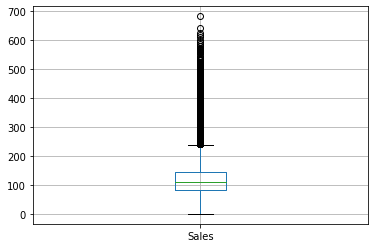

In [ ]:
train[['Sales']].boxplot()

We can find that there are outliers in the Sales data.
Let's also look at the distribution plot for the Sales column.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


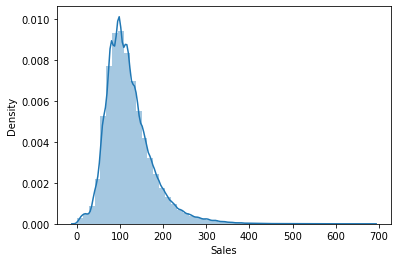

In [ ]:
sns.distplot(train['Sales'])

* From the distribution of we can find that Sales do not follow normal distribution
* Sales is postively skewed

Let's look at the Skewness and Kurtosis values for the Sales column.

In [ ]:
print("Skewness= ", train['Sales'].skew())
print("Kurtosis= ", train['Sales'].kurt())

Skewness=  1.374769816079381
Kurtosis=  3.6095060518605546


Since kutosis is > 3, we can conclude that Distribution is longer, has Many Outliers.

Later we will apply a log transformation on the Sales column to reduce the skewness.

<h4>Analysis of Day_Number</h4>

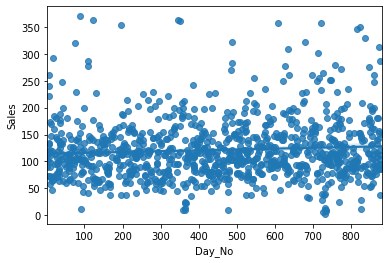

In [ ]:
# plotting on sample of dataset
sampletrain= train.sample(1000)
sns.regplot(x='Day_No',y='Sales',data= sampletrain)

As we can see from the above graph, We can say that Day_No is not a good estimator

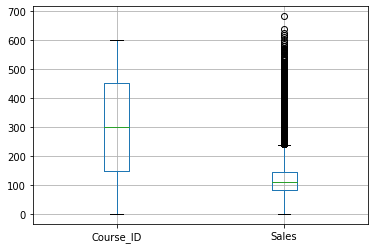

In [ ]:
train[['Course_ID','Sales']].boxplot()

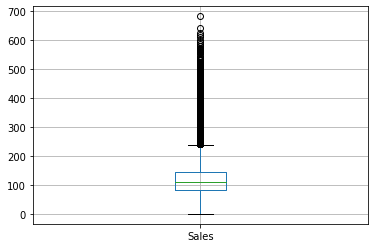

In [ ]:
train[['Course_Domain','Sales']].boxplot()

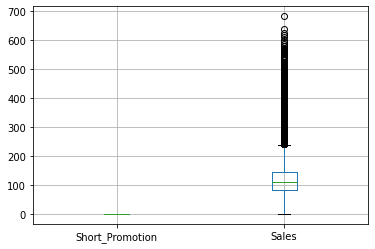

In [ ]:
train[['Short_Promotion','Sales']].boxplot()

From the above graphs we can conclude that data can be normalised before fiting it into a models

<h4> Correlation analysis</h4>

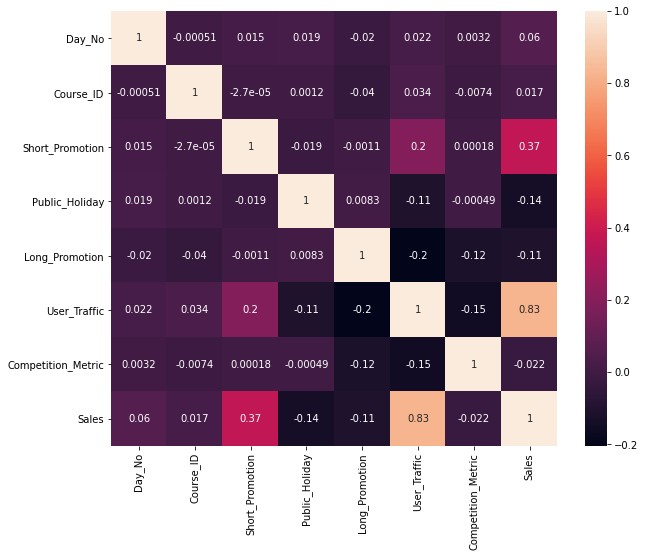

In [ ]:
# Lets find the correlation
plt.subplots(figsize=(10,8))
sns.heatmap(train.corr(), annot= True)

In [ ]:
train.corr().unstack().sort_values().drop_duplicates()

User_Traffic        Long_Promotion       -0.204289
Competition_Metric  User_Traffic         -0.148775
Public_Holiday      Sales                -0.135052
Long_Promotion      Competition_Metric   -0.119382
Sales               Long_Promotion       -0.109455
Public_Holiday      User_Traffic         -0.108305
Long_Promotion      Course_ID            -0.039605
Sales               Competition_Metric   -0.022085
Day_No              Long_Promotion       -0.020204
Short_Promotion     Public_Holiday       -0.018770
Competition_Metric  Course_ID            -0.007385
Short_Promotion     Long_Promotion       -0.001149
Course_ID           Day_No               -0.000506
Competition_Metric  Public_Holiday       -0.000491
Course_ID           Short_Promotion      -0.000027
Competition_Metric  Short_Promotion       0.000182
Public_Holiday      Course_ID             0.001242
Day_No              Competition_Metric    0.003229
Public_Holiday      Long_Promotion        0.008319
Day_No              Short_Promo

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


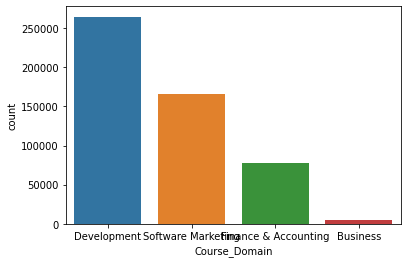

In [ ]:
sns.countplot(train['Course_Domain'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


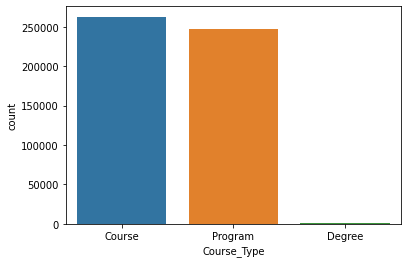

In [ ]:
sns.countplot(train['Course_Type'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


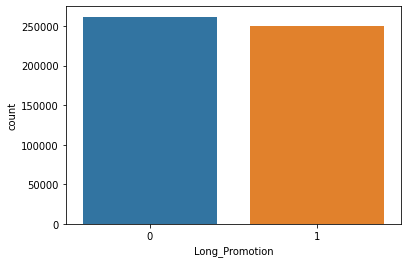

In [ ]:
sns.countplot(train['Long_Promotion'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


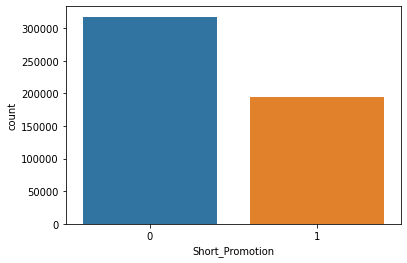

In [ ]:
sns.countplot(train['Short_Promotion'])

* There are very few rows which have Business as the Course Domain.
* There are also very few rows which have Degree as Course Type
* There are almost equal distribution among the Long Promotion category whereas the same thing cannot be said among Short Promotion.

Let's look at how the sales are varying across a particular Course by Day.

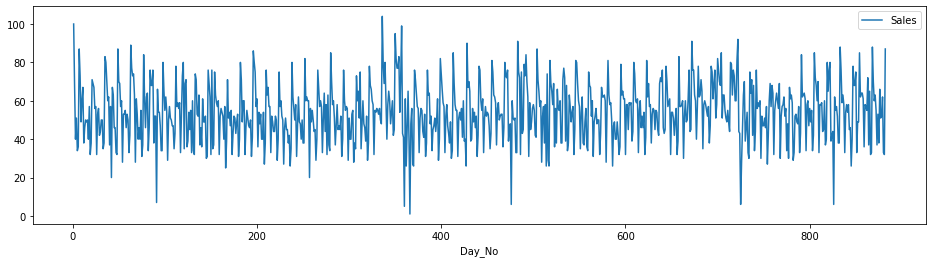

In [ ]:
sample_train = train[train.Sales>0] # Sales cannot be zero
sample_train[sample_train['Course_ID']==132][['Day_No','Sales']].plot(x='Day_No',y='Sales',figsize=(16,4))

Let's look at the distribution of Competition_Metric

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


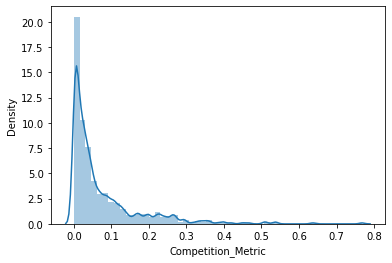

In [ ]:
sns.distplot(train['Competition_Metric'])

We can see that the Competition Metric is slightly positively skewed.


<h4>Feature Engineering</h4>

Converting Day_No to corresponding date and then date to day, month,year and Week of Year

In [ ]:
def day_to_date(dataset):
    start = date(2018,12,31)
    dataset['Date'] = dataset['Day_No'].apply(lambda x: start + timedelta(x))

def day_month_year(dataset): 
    dataset['Day'] = dataset['Date'].apply(lambda x: x.day)
    dataset['Month'] = dataset['Date'].apply(lambda x: x.month)
    dataset['Year'] = dataset['Date'].apply(lambda x: x.year)
    dataset["Date"] = pd.to_datetime(dataset["Date"]) 
    dataset['weekofyear'] = dataset['Date'].dt.weekofyear

In [ ]:
day_to_date(train)
day_month_year(train)
day_to_date(test)
day_month_year(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


Since test doesnt contain User Traffic, we are removing it

In [ ]:
train.drop('User_Traffic',axis =1, inplace = True)

In [ ]:
print(train.columns)
print(test.columns)

Index(['Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Sales', 'Date', 'Day', 'Month', 'Year',
       'weekofyear'],
      dtype='object')
Index(['Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Date', 'Day', 'Month', 'Year', 'weekofyear'],
      dtype='object')


In [ ]:
train['Competition_Metric'] = train.groupby('Course_ID').transform(lambda x: x.fillna(x.mean()))

In [ ]:
# merge train and test
df = train.append(test)

In [ ]:
df.isna().sum()

Day_No                    0
Course_ID                 0
Course_Domain             0
Course_Type               0
Short_Promotion           0
Public_Holiday            0
Long_Promotion            0
Competition_Metric     1884
Sales                 36000
Date                      0
Day                       0
Month                     0
Year                      0
weekofyear                0
dtype: int64

Imputing Missing values in Competition Metric by replacing it with the mean in the corresponding Course group

In [ ]:
for course_id in train1.Course_ID.unique():
        train1[train1['Course_ID']==course_id]['Competition_Metric'].fillna(train1[train1['Course_ID'==course_id]]['Competition_Metric'].median())

In [ ]:
for course_id in train1.Course_ID.unique():
        test1[test1['Course_ID']==course_id]['Competition_Metric'].fillna(test1[test1['Course_ID'==course_id]]['Competition_Metric'].median())

One-hot Encoding the Course Domain, Course Type values(Converting categorical to numerical types)

In [ ]:
df1=pd.get_dummies(df,columns=['Course_Domain','Course_Type'],drop_first=True)

In [ ]:
df1.dtypes


Day_No                                         int64
Course_ID                                      int64
Short_Promotion                                int64
Public_Holiday                                 int64
Long_Promotion                                 int64
Competition_Metric                           float64
Sales                                        float64
Date                                  datetime64[ns]
Day                                            int64
Month                                          int64
Year                                           int64
weekofyear                                     int64
Course_Domain_Development                      uint8
Course_Domain_Finance & Accounting             uint8
Course_Domain_Software Marketing               uint8
Course_Type_Degree                             uint8
Course_Type_Program                            uint8
dtype: object

Creating Day of week from Day_No

In [ ]:
df1['Day_of_week']=df1['Day_No'].apply(lambda x:x%7)

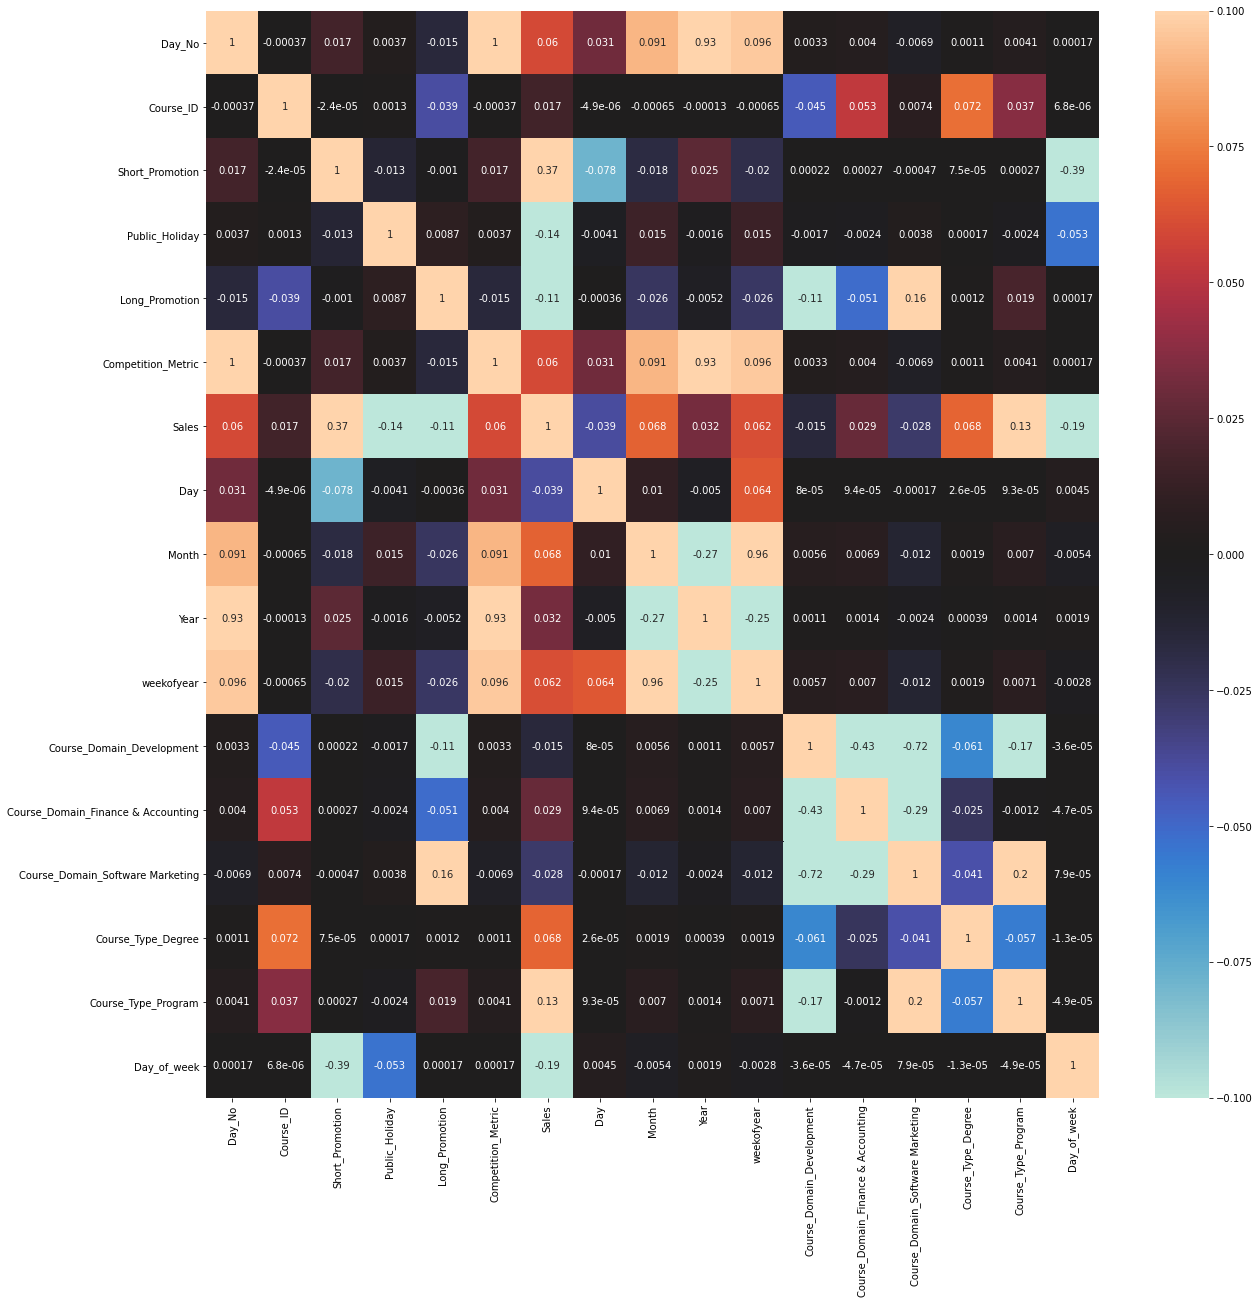

In [ ]:
plt.subplots(figsize=(20,20))
sns.heatmap(df1.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)

From the above correlation heatmap, we can observe that the newly created features Day, Month, Year have high correlation with Day_No and Date. So, I am dropping the Day_No and Date columns.

In [ ]:
df1.drop(['Day_No','Date'],axis = 1,inplace = True)

In [ ]:
#splitting train and test from df
train1= df1[df1['Sales'].isnull()!= True]
test1= df1[df1['Sales'].isnull()== True].drop(['Sales'], axis=1)
print(train1.shape)
print(test1.shape)

(512087, 16)
(36000, 15)


In [ ]:
print(train1.columns)
print(test1.columns)

Index(['Course_ID', 'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Sales', 'Day', 'Month', 'Year', 'weekofyear',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program', 'Day_of_week'],
      dtype='object')
Index(['Course_ID', 'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Day', 'Month', 'Year', 'weekofyear',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program', 'Day_of_week'],
      dtype='object')


This is a function that reduces the memory used by the dataframe in storage.It reduces the memory by assigning the right kind of datatype to the columns in our dataset by analysing the largest value in each column.

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
%%time
train1= reduce_mem_usage(train1)
test1= reduce_mem_usage(test1)

Mem. usage decreased to 13.67 Mb (72.3% reduction)
Mem. usage decreased to  0.89 Mb (72.0% reduction)
CPU times: user 110 ms, sys: 1.16 ms, total: 112 ms
Wall time: 120 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

<h4>Model Building</h4>

I have experimented with multiple models such as XGBoostRegressor, LGBRegressor and H20AutoML.Though LGBMRegressor and H20AutoML performed good on the training set, the RMSLE*1000 score upon submission were more compared to the model compared to base LGB model.So I proceeded to use that along with Bayesian Optimization for Hyperparameter Tuning.The implementations of the XGBoost and H20AutoML models can be found under the section Other Models

LGBM with Bayesian Optimization

1.Getting the best parameters

In [ ]:
%%time
X_train = train1.drop('Sales',axis=1)
Y_train = np.log1p(train1.Sales)
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    def rmsle(preds, lgb_train):
        eval_name = "rmsle"
        eval_result = np.sqrt(mean_squared_log_error(preds, lgb_train.get_label()))
        return (eval_name, eval_result*1000, False)
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,reg_alpha, reg_lambda,subsample):
        params = {'objective':'gamma', 'metric':'rmse','task':'train'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['reg_lambda'] = float(reg_lambda)
        params['reg_alpha'] = float(reg_alpha)
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed,feval=rmsle,stratified=False, verbose_eval =200, metrics=['rmse'])
        return (-1.0 * np.array(cv_result['rmse-mean'])).max()
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'reg_lambda': (0.1, 1),
                                            'reg_alpha': (0.1, 1),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round,acq='ei')
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    ## return best parameters 
    # return lgbBO.res['max']['max_params']
    # return optimizer.max
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X_train, Y_train, init_round=10, opt_round=10, n_folds=5, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2768   |  0.9895   |  0.2812   |  0.5985   |  49.98    |  24.1     |  20.17    |  35.74    |  74.94    |  0.5105   |  0.9836   |  0.8687   |
|  2        | -0.2194   |  0.9972   |  0.8386   |  0.3107   |  79.23    |  8.031    |  67.13    |  25.05    |  29.38    |  0.9491   |  0.8434   |  0.5231   |
|  3        | -0.2307   |  0.9747   |  0.5627   |  0.4556   |  67.61    |  15.49    |  58.42    |  60.87    |  29.9     |  0.9694   |  0.7828   |  0.6828   |
|  4        | -0.4067   |  0.8659   |  0.1212   |  0.8056   |  88.1     |  12.07    |  58.94    |  26.56    |  34.51    |  0.4771   |  0.6994   |  0.5222   |
|  5        | -0.2657   |  0.9709   |  0.2368   |  0

In [ ]:
opt_params

(-0.18476368395202555,
 {'bagging_fraction': 0.945328354877452,
  'feature_fraction': 0.6794460921764023,
  'learning_rate': 0.5021558629186151,
  'max_bin': 66.60287732590848,
  'max_depth': 26.043734340784358,
  'min_data_in_leaf': 34.42390529913832,
  'min_sum_hessian_in_leaf': 24.922537940382195,
  'num_leaves': 66.41645422053622,
  'reg_alpha': 0.2794403838240256,
  'reg_lambda': 0.19901597467105386,
  'subsample': 0.34814142455066416})

In [ ]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='gamma'
opt_params[1]['metric']='rmse'
# opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 0.945328354877452,
 'feature_fraction': 0.6794460921764023,
 'learning_rate': 0.5021558629186151,
 'max_bin': 67,
 'max_depth': 26,
 'metric': 'rmse',
 'min_data_in_leaf': 34,
 'min_sum_hessian_in_leaf': 24.922537940382195,
 'num_leaves': 66,
 'objective': 'gamma',
 'reg_alpha': 0.2794403838240256,
 'reg_lambda': 0.19901597467105386,
 'subsample': 0.34814142455066416}

2.Training the LGBM model

LGB 0--------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.103322	training's rmsle: 103.322	valid_1's rmse: 0.119517	valid_1's rmsle: 119.517
Early stopping, best iteration is:
[1589]	training's rmse: 0.0988135	training's rmsle: 98.8135	valid_1's rmse: 0.118692	valid_1's rmsle: 118.692
LGB 1--------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.101771	training's rmsle: 101.771	valid_1's rmse: 0.119585	valid_1's rmsle: 119.585
Early stopping, best iteration is:
[1395]	training's rmse: 0.0984767	training's rmsle: 98.4767	valid_1's rmse: 0.118976	valid_1's rmsle: 118.976
LGB 2--------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.101595	training's rmsle: 101.595	valid_1's rmse: 0.117336	valid_1's rmsle: 117.336
Early stopping, best itera

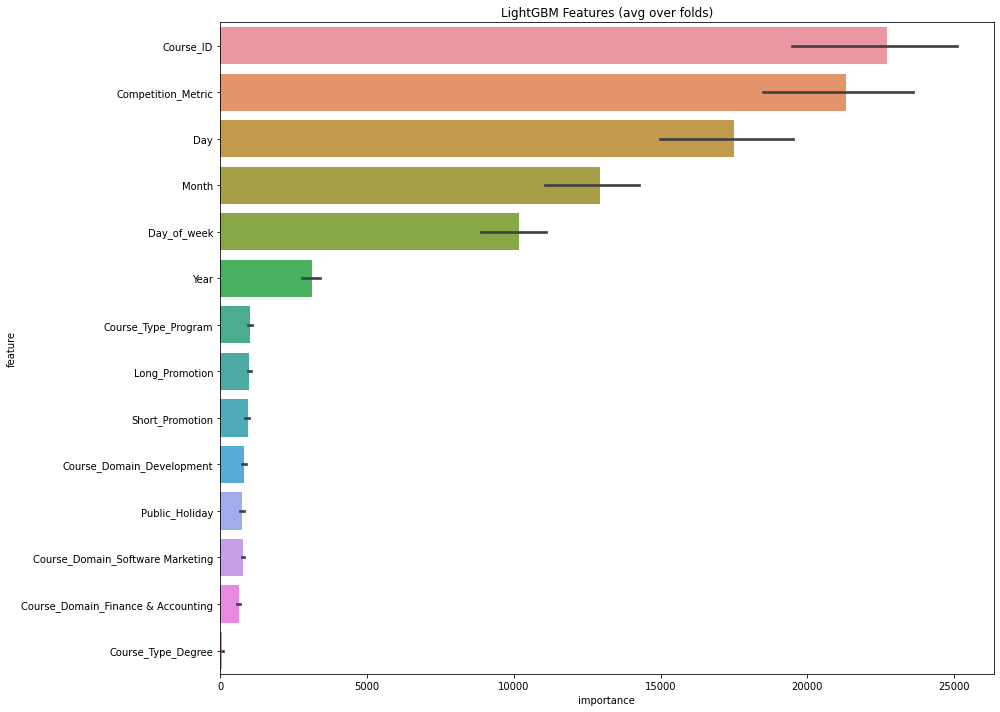

In [ ]:
# run_lgb = True
X_train=train1.drop('Sales',axis=1)
Y_train=np.log1p(train1.Sales)
X_test=test1.copy()
# print('LGB : ', run_lgb)
# modeling
#--------------------------------------------------------------------------
# if run_lgb:
import lightgbm as lgb
def rmsle(y, yhat):
    return (np.sqrt(mean_squared_log_error(y, yhat)))*1000

def rmsle_xg(yhat, y):
    # print(y.get_label())
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return ("rmsle", rmsle(y,yhat),False)

def kfold_lgb_xgb():
    folds = KFold(n_splits=5, shuffle=True, random_state=7)
    
    oof_lgb = np.zeros(len(X_train))
    predictions_lgb = np.zeros(len(X_test))

    features_lgb = list(X_train.columns)
    feature_importance_df_lgb = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=Y_train.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=Y_train.iloc[val_idx])
        
        print("LGB " + str(fold_) + "-" * 50)
        num_round = 20000
        clf = lgb.train(opt_params, trn_data, num_round,feval=rmsle_xg,valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
        oof_lgb[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
        
        fold_importance_df_lgb = pd.DataFrame()
        fold_importance_df_lgb["feature"] = features_lgb
        fold_importance_df_lgb["importance"] = clf.feature_importance()
        fold_importance_df_lgb["fold"] = fold_ + 1
        feature_importance_df_lgb = pd.concat([feature_importance_df_lgb, fold_importance_df_lgb], axis=0)
        predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
    
    #lgb.plot_importance(clf, max_num_features=30)    
    cols = feature_importance_df_lgb[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features_lgb = feature_importance_df_lgb.loc[feature_importance_df_lgb.feature.isin(cols)]
    plt.figure(figsize=(14,10))
    sns.barplot(x="importance", y="feature", data=best_features_lgb.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')
    x = []
    for i in oof_lgb:
        if i < 0:
            x.append(0.0)
        else:
            x.append(i)
    cv_lgb = mean_squared_error(x, Y_train)**0.5
    cv_lgb = str(cv_lgb)
    cv_lgb = cv_lgb[:10]
    
    pd.DataFrame({'preds': x}).to_csv('lgb_oof_' + cv_lgb + '.csv', index = False)
    
    print("CV_LGB : ", cv_lgb)
    return cv_lgb, predictions_lgb
    
cv_lgb, lgb_ans = kfold_lgb_xgb()

In [ ]:
 x = []
 ze=[]
for i in lgb_ans:
    if i < 0:
        x.append(0.0)
        ze.append(0)
    else:
        x.append(i)
np.save('lgb_ans.npy', x)
print(ze)


[]


In [ ]:
sample.head()

,ID,Sales_by_lgbm,XG Boost,LightGBM,H20
0,883,120.747232,4.845521,4.832927,120.073727
1,884,119.551457,4.767631,4.801457,117.523781
2,885,112.741565,4.746264,4.734630,101.792717
3,886,102.096318,4.697353,4.689135,100.509282
4,887,57.957711,4.246499,4.156295,56.011247


In [ ]:
submission = pd.DataFrame()
submission['ID'] = sample['ID']
submission['Sales'] = np.expm1(x)
submission.to_csv('lgb_with_bayesian_opt.csv', index=False)
submission.head()

,ID,Sales
0,883,117.481878
1,884,124.310169
2,885,105.031230
3,886,97.431807
4,887,59.824337


Other models tested

In [ ]:
# submission = test1[['ID']].copy()
# submission.loc[:, 'Sales'] = x
# submission["Sales"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
# submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)
# grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
# grouped_test.to_csv('lgb_' + cv_lgb + '.csv',index=False)

In [ ]:
# train_data=X_train.copy()
# train_label = Y_train
# NFOLDS = 5
# kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
# kf = kfold.split(train_data, train_label)
# cv_pred = np.zeros(test_data.shape[0])
# valid_best_l2_all = 0
# feature_importance_df = pd.DataFrame()

# #Executive training
# for i, (train_fold, validate) in enumerate(kf):
#     X_train, X_validate, label_train, label_validate = \
#     train_data.iloc[train_fold, :], train_data.iloc[validate, :], \
#     train_label[train_fold], train_label[validate]
    
#     dtrain = lgb.Dataset(X_train, label_train)
#     dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
    
#     bst = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=dvalid, verbose_eval=-1,early_stopping_rounds=50)
    
# 	cv_pred += bst.predict(test_data_use, num_iteration=bst.best_iteration)
#     valid_best_l2_all += bst.best_score['valid_0']['l1']
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = list(X_train.columns)
#     fold_importance_df["importance"] = bst.feature_importance(importance_type='gain', iteration=bst.best_iteration)
#     fold_importance_df["fold"] = count + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     count += 1

# cv_pred /= NFOLDS
# valid_best_l2_all /= NFOLDS
# print('cv score for valid is: ', 1/(1+valid_best_l2_all))

# def display_importances(feature_importance_df_):
#     cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
#     best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
#     plt.figure(figsize=(8, 10))
#     sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
#     plt.title('LightGBM Features (avg over folds)')
#     plt.tight_layout()
#     plt.show()
    
# display_importances(feature_importance_df)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
def rmsle1000(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2))) *1000

In [ ]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

In [ ]:
X_train = train1[:int(0.7*len(train1))]
X_test = train1[int(0.7*len(train1)):]
# Y_train = np.log1p(train1.Sales)
print(X_train.shape)
print(X_test.shape)

(358460, 15)
(153627, 15)


In [ ]:
X_tr = X_train.drop('Sales',axis=1)
X_val = X_test.drop('Sales',axis=1)
y_tr = np.log1p(X_train.Sales)
y_val = np.log1p(X_test.Sales)

In [ ]:
xgb = XGBRegressor(n_estimators= 500)
xgb.fit(X_train,Y_train)
xgb_preds = xgb.predict(X_test)

[06:50:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# for submission
lgbm = LGBMRegressor(n_estimators= 500)
lgbm.fit(X_train, Y_train)
lgbm_preds = lgbm.predict(X_test)

In [ ]:
print(xgb_preds)

[4.8455215 4.767631  4.746264  ... 4.857803  4.9514785 5.0390315]


In [ ]:
print(lgbm_preds)

[4.83292689 4.80145708 4.7346297  ... 4.87742653 5.01321916 5.03492036]


In [ ]:
print(train1.columns)
print(test1.columns)

Index(['Course_ID', 'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Sales', 'Day', 'Month', 'Year',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program'],
      dtype='object')
Index(['Course_ID', 'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Day', 'Month', 'Year',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program'],
      dtype='object')


In [ ]:
!pip install h2o

In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()
train = h2o.H2OFrame(train1)
test = h2o.H2OFrame(test1)


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 6 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,16 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_unknownUser_6zoqen
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.980 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
y = "Sales"
x = list(X_train.columns)
aml = H2OAutoML(max_models = 30, max_runtime_secs=300, seed = 1)
aml.train(x = x, y = y, training_frame = train)
lb = aml.leaderboard
lb.head()
lb.head(rows=lb.nrows)
preds = aml.predict(test)
water_preds=h2o.as_list(preds) 

AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [ ]:
water_preds

,predict
0,120.073727
1,117.523781
2,101.792717
3,100.509282
4,56.011247
...,...
35995,179.057374
35996,138.019160
35997,132.485054
35998,147.885778


In [ ]:
sample.rename(columns = {'Sales':'Sales_by_lgbm'},inplace = True)

In [ ]:
sample['XG Boost'] = xgb_preds

In [ ]:
sample['LightGBM'] = lgbm_preds

In [ ]:
sample['H20'] = water_preds

In [ ]:
#Predictions of various modles
sample

,ID,Sales_by_lgbm,XG Boost,LightGBM,H20
0,883,120.747232,4.845521,4.832927,120.073727
1,884,119.551457,4.767631,4.801457,117.523781
2,885,112.741565,4.746264,4.734630,101.792717
3,886,102.096318,4.697353,4.689135,100.509282
4,887,57.957711,4.246499,4.156295,56.011247
...,...,...,...,...,...
35995,548083,161.659816,4.984985,5.066349,179.057374
35996,548084,132.946349,4.848502,4.897064,138.019160
35997,548085,135.652238,4.857803,4.877427,132.485054
35998,548086,155.337408,4.951478,5.013219,147.885778


In [ ]:
submission = pd.DataFrame()
submission['ID'] = sample['ID']
submission['Sales'] = np.expm1(predictions)
submission.to_csv('predictions_1.csv', index=False)
submission.head()

,ID,Sales
0,883,120.747232
1,884,119.551457
2,885,112.741565
3,886,102.096318
4,887,57.957711


In [ ]:
submission = pd.DataFrame()
submission['ID'] = sample['ID']
submission['Sales'] = np.expm1(xgb_preds)
submission.to_csv('xgb_2.csv', index=False)
submission.head()

,ID,Sales
0,883,126.169579
1,884,116.640228
2,885,114.153267
3,886,108.656570
4,887,68.860405


In [ ]:
submission2 = pd.DataFrame()
submission2['ID'] = sample['ID']
submission2['Sales'] = np.expm1(lgbm_preds)
submission2.to_csv('lgbm_2.csv', index=False)
submission2.head()

,ID,Sales
0,883,124.577976
1,884,120.687597
2,885,112.821302
3,886,107.759055
4,887,62.834587


In [ ]:
submission2 = pd.DataFrame()
submission2['ID'] = sample['ID']
submission2['Sales'] = np.expm1(water_preds)
submission2.to_csv('h2o_water.csv', index=False)
submission2.head()

,ID,Sales
0,883,111.575145
1,884,112.192065
2,885,112.015095
3,886,112.302547
4,887,75.880790
